In [15]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pylab as plt
import numpy as np
import xarray as xr
import cmaps
import matplotlib as mpl
import sacpy as scp
import matplotlib.path as mpath  
from cartopy.util import add_cyclic_point
import sys
sys.path.append("/public/home/songqh/Documents/python_packages")
from sqh_toolbox import plot_figure
from waf import tnwaf
plt.rcParams["font.family"] = "Liberation Sans"
plt.rcParams["font.weight"] = "regular"
import warnings
warnings.filterwarnings("ignore")

In [16]:
ds_sst = xr.open_dataset("/public/home/songqh/my_data/SST/HadISST_sst.nc")
nino34 = ds_sst['sst'].loc[ds_sst.time.dt.year.isin(np.arange(1979,2025)) & ds_sst.time.dt.month.isin([6,7,8]),5:-5,-170:-120].mean(('longitude','latitude')).values.reshape((46,3)).mean(1)
nino34 = (nino34 - nino34.mean())/np.std(nino34)
dmi_w = ds_sst['sst'].loc[ds_sst.time.dt.year.isin(np.arange(1979,2025)) & ds_sst.time.dt.month.isin([6,7,8]),10:-10,50:70].mean(('longitude','latitude')).values.reshape((46,3)).mean(1)
dmi_e = ds_sst['sst'].loc[ds_sst.time.dt.year.isin(np.arange(1979,2025)) & ds_sst.time.dt.month.isin([6,7,8]),0:-10,90:110].mean(('longitude','latitude')).values.reshape((46,3)).mean(1)
dmi = dmi_w - dmi_e
dmi = (dmi - dmi.mean())/np.std(dmi)

In [17]:
file1 = xr.open_dataset("/public/home/songqh/my_data/new_ERA5/monthly/ERA5_precipitation_1979-2024.nc")
precip_index = file1['tp'].loc[file1.time.dt.year.isin(np.arange(1979,2025,1))&file1.time.dt.month.isin([6,7,8]),28:10,70:100].groupby('time.year').mean('time').rename({'year':'time'}).mean(('longitude','latitude'))*1000
precip_index = (precip_index - np.mean(precip_index,axis=0))/np.std(precip_index)

In [18]:
file0 = xr.open_dataset("/public/home/songqh/my_data/ice_cover/HadISST_ice.nc")
sic = file0['sic'].loc[file0.time.dt.year.isin(np.arange(1979,2025,1))
                        & file0.time.dt.month.isin([6,7,8])].groupby('time.year').mean('time')
lon0 = file0['longitude']
lat0 = file0['latitude']

In [19]:
gph = np.load("/public/home/songqh/project/ISM_impact_Antarctic/data/gph_200hPa_1979-2024.npy")
uwnd = np.load("/public/home/songqh/project/ISM_impact_Antarctic/data/uwnd_200hPa_1979-2024.npy")
vwnd = np.load("/public/home/songqh/project/ISM_impact_Antarctic/data/vwnd_200hPa_1979-2024.npy")
u10 = np.load("/public/home/songqh/project/ISM_impact_Antarctic/data/u10_1979-2024.npy")
v10 = np.load("/public/home/songqh/project/ISM_impact_Antarctic/data/v10_1979-2024.npy")
t2m = np.load("/public/home/songqh/project/ISM_impact_Antarctic/data/t2m_1979-2024.npy")
slp = np.load("/public/home/songqh/project/ISM_impact_Antarctic/data/slp_1979-2024.npy")
lon = np.load("/public/home/songqh/project/ISM_impact_Antarctic/data/lon.npy")
lat = np.load("/public/home/songqh/project/ISM_impact_Antarctic/data/lat.npy")
ds_rws = xr.open_dataset("/public/home/songqh/project/ISM_impact_Antarctic/data/rws_output.nc")
rws =  ds_rws['s1']

In [20]:
X = np.vstack((precip_index,nino34,dmi)).T
MLR0 = scp.MultLinReg(X,sic[:])
MLR1 = scp.MultLinReg(X,gph[:])
MLR2 = scp.MultLinReg(X,slp[:])
MLR3 = scp.MultLinReg(X,t2m[:])
MLR4 = scp.MultLinReg(X,u10[:])
MLR5 = scp.MultLinReg(X,v10[:])
MLR6 = scp.MultLinReg(X,rws[:])
u10_copy = np.where((MLR4.pv_i > 0.05) & (MLR5.pv_i > 0.05) , np.nan, MLR4.slope)
v10_copy = np.where((MLR4.pv_i > 0.05) & (MLR5.pv_i > 0.05) , np.nan, MLR5.slope)

In [21]:
px = np.full((181,360),np.nan)
py = np.full((181,360),np.nan)
_,px,py= tnwaf(MLR1.slope[0],uwnd,vwnd,lon,lat,200)
px[:110],py[:110]=np.nan,np.nan
px[np.sqrt(px**2+py**2)<0.01]=np.nan
py[np.sqrt(px**2+py**2)<0.01]=np.nan

In [22]:
def get_cmap_pr(n_colors: int, newcmap , method: int = None) -> list:
    index = list(range(1, n_colors + 1))
    color_list = [newcmap(i / n_colors) for i in index]
    if method == 1:
        color_list[0] = [1., 1., 1.]  
    elif method == 2:
        mid_index = len(color_list) // 2
        color_list[mid_index] = [1., 1., 1.]  
        color_list[mid_index - 1] = [1., 1., 1.]
    return color_list
new_CBR_coldhot = mpl.colors.ListedColormap(get_cmap_pr(18,cmaps.CBR_coldhot,method=2))
new_cmocean_balance_r = mpl.colors.ListedColormap(get_cmap_pr(20,cmaps.cmocean_balance_r,method=2))

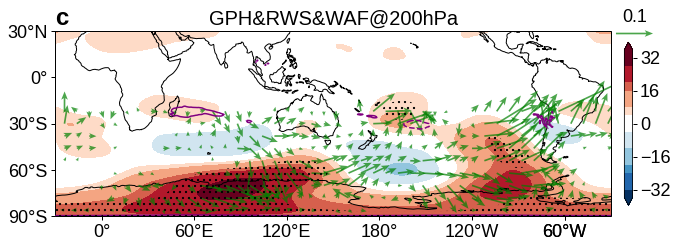

In [23]:
cycle_gph,cycle_lon = add_cyclic_point(MLR1.slope[0], coord=lon)
cycle_rws,cycle_lon = add_cyclic_point(MLR6.slope[0], coord=lon)
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111,projection = ccrs.PlateCarree(central_longitude=150))
ax1.draw_map([-60,280,-90,30],latspec=30)
ax1.set_title("GPH&RWS&WAF@200hPa",fontsize=20,loc='center')
ax1.set_title("c",fontsize=24,weight='bold',loc='left')
cf1 = ax1.contourf(cycle_lon,lat,cycle_gph/9.8, zorder=2,
        levels=np.arange(-36,40,4),extend = 'both',
        transform=ccrs.PlateCarree(), cmap=new_CBR_coldhot)
kk=8
q = ax1.quiver(lon[::kk],lat[::kk],px[::kk,::kk],py[::kk,::kk],alpha=0.7,color='g',scale=1.5, 
               width=0.003,headwidth=4, headlength=5, headaxislength=4, zorder=3,transform=ccrs.PlateCarree())
qk = ax1.quiverkey(q, 1.042, 0.99, U=0.1, label='0.1',labelpos='N',
        zorder=3, coordinates='axes',color='g',fontproperties={'size': 18},labelcolor='k')
ax1.contour(cycle_lon,lat, cycle_rws,colors='purple', zorder=3,levels=[1,2],lw=3,transform=ccrs.PlateCarree())
ax1.contour(cycle_lon,lat, cycle_rws,colors='purple', zorder=3,levels=[-2,-1],lw=3,transform=ccrs.PlateCarree())
ax1.contourf(lon,lat,  MLR1.pv_i[0], levels =[0,0.05,1],hatches=['..', None], 
                 zorder=3,colors="none", transform=ccrs.PlateCarree())
cb = fig.colorbar(cf1,orientation='vertical',shrink=0.5,pad=0.02)
cb.ax.set_colorbar(minor='off')
cb.set_ticks(np.arange(-32, 48, 16))
fig.savefig("/public/home/songqh/project/ISM_impact_Antarctic/figures/response_figures/support-3c.jpeg",dpi=600, bbox_inches='tight')

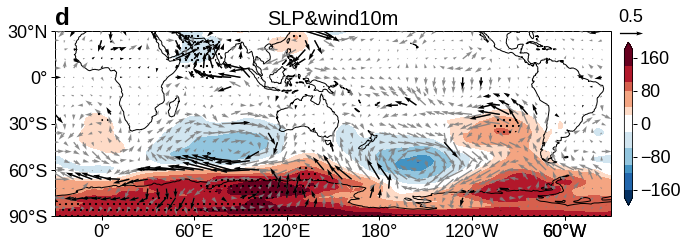

In [24]:
cycle_slope,cycle_lon = add_cyclic_point(MLR2.slope[0], coord=lon)
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111,projection = ccrs.PlateCarree(central_longitude=150))
ax1.draw_map([-60,280,-90,30],latspec=30)
ax1.set_title("SLP&wind10m",fontsize=20,loc='center')
ax1.set_title("d",fontsize=24,weight='bold',loc='left')
cf1 = ax1.contourf(cycle_lon,lat,cycle_slope, zorder=2,levels=np.arange(-180,200,20),  
                   extend = 'both',transform=ccrs.PlateCarree(), cmap=new_CBR_coldhot)
kk = 6
ax1.quiver(lon[::kk],lat[::kk],MLR4.slope[0,::kk,::kk],MLR5.slope[0,::kk,::kk],alpha=0.9,color='gray',scale=12,
           zorder=3,transform=ccrs.PlateCarree())
q = ax1.quiver(lon[::kk],lat[::kk],u10_copy[0,::kk,::kk],v10_copy[0,::kk,::kk],color='k',scale=12,
           zorder=3,transform=ccrs.PlateCarree())
qk = ax1.quiverkey(q, 1.036, 0.99, U=0.5, label='0.5',labelpos='N',zorder=3, 
                   coordinates='axes',color='k',fontproperties={'size': 18},labelcolor='k')
ax1.contourf(lon,lat, MLR2.pv_i[0], levels =[0,0.05,1],hatches=['..', None], 
                 zorder=3,colors="none", transform=ccrs.PlateCarree())
cb = fig.colorbar(cf1,orientation='vertical',shrink=0.5,pad=0.02)
cb.ax.set_colorbar(minor='off')
cb.set_ticks(np.arange(-160, 200, 80))
fig.savefig("/public/home/songqh/project/ISM_impact_Antarctic/figures/response_figures/support-3d.jpeg",dpi=600, bbox_inches='tight')

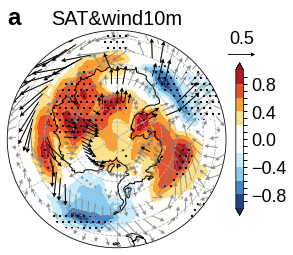

In [25]:
cycle_slope,cycle_lon = add_cyclic_point(MLR3.slope, coord=lon)
theta = np.linspace(0, 2*np.pi, 100)  
center, radius = [0.5, 0.5], 0.5  
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)  
fig = plt.figure(figsize=(5, 4))
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=120.0, central_latitude=-90.0, globe=None))
ax.set_extent([-180, 180, -50, -90], ccrs.PlateCarree())
gl = ax.gridlines(linestyle='--',zorder=2)
ax.set_boundary(circle, transform=ax.transAxes)  
ax.add_feature(cfeature.COASTLINE.with_scale('110m'),linewidth=1,zorder=3) 
MLR4.slope[0,170:182,:],MLR5.slope[0,170:182,:] = np.nan, np.nan
u10_copy[0,170:182,:],v10_copy[0,170:182,:] = np.nan, np.nan
kk = 6
q = ax.quiver(lon[::kk],lat[::kk],MLR4.slope[0,::kk,::kk],MLR5.slope[0,::kk,::kk],color='gray',
           alpha=0.9,zorder=3,scale=4,headwidth=5,width=0.004,transform=ccrs.PlateCarree())
q = ax.quiver(lon[::kk],lat[::kk],u10_copy[0,::kk,::kk],v10_copy[0,::kk,::kk],color='k',
              zorder=3,scale=4,headwidth=5,width=0.004,transform=ccrs.PlateCarree())
qk = ax.quiverkey(q, 1.07, 0.89, U=0.5, label='0.5',labelpos='N',
    zorder=3, coordinates='axes',color='k',fontproperties={'size': 18},
    labelcolor='k')
cf1 = ax.contourf(cycle_lon,lat,cycle_slope[0], zorder=2,levels=np.linspace(-1,1,11),  
                   extend = 'both',transform=ccrs.PlateCarree(), cmap=cmaps.BlueWhiteOrangeRed)
ax.contourf(lon,lat, MLR3.pv_i[0], levels =[0,0.05,1],hatches=['..', None], 
                 zorder=3,colors="none", transform=ccrs.PlateCarree())
cb = fig.colorbar(cf1,orientation='vertical',shrink=0.7,pad=0.035)
cb.ax.set_colorbar()
ax.set_title("SAT&wind10m",fontsize=20,loc='center')
ax.set_title("a",weight='bold',fontsize=24,loc='left')

fig.savefig("/public/home/songqh/project/ISM_impact_Antarctic/figures/response_figures/support-3a.jpeg",dpi=600, bbox_inches='tight')

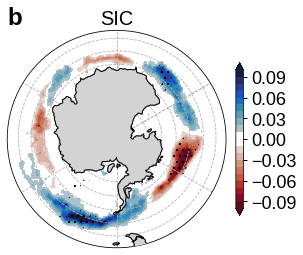

In [26]:
cycle_slope,cycle_lon = add_cyclic_point(MLR0.slope, coord=lon0)
leftlon, rightlon, lowerlat, upperlat = (-180,180,-50,-90)
img_extent = [leftlon, rightlon, lowerlat, upperlat]
fig = plt.figure(figsize=(5,4))
ax1 = plt.axes(projection=ccrs.Orthographic(central_longitude=120.0, central_latitude=-90.0, globe=None))
ax1.gridlines(linestyle='--',zorder=2)
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax1.set_boundary(circle, transform=ax1.transAxes)
ax1.add_feature(cfeature.COASTLINE.with_scale('110m'),color='k',linewidth=1,zorder=3)
ax1.add_feature(cfeature.LAND, facecolor='lightgray',zorder=3)
ax1.coastlines(resolution='110m', color='black', linewidth=1,zorder=3)
ax1.set_extent(img_extent, ccrs.PlateCarree())
cf1 = ax1.contourf(cycle_lon,lat0,cycle_slope[0], zorder=2,levels=np.linspace(-0.1,0.1,21),  
                   extend = 'both',transform=ccrs.PlateCarree(), cmap=new_cmocean_balance_r)
ax1.contourf(lon0,lat0, MLR0.pv_i[0], levels =[0,0.05,1],hatches=['..', None], 
                 zorder=3,colors="none", transform=ccrs.PlateCarree())
cb = fig.colorbar(cf1,orientation='vertical',shrink=0.7,pad=0.035)
cb.ax.set_colorbar(minor='off')
ax1.set_title("SIC",fontsize=20,loc='center')
ax1.set_title("b",weight='bold',fontsize=24,loc='left')

fig.savefig("/public/home/songqh/project/ISM_impact_Antarctic/figures/response_figures/support-3b.jpeg",dpi=600, bbox_inches='tight')

In [27]:
file3 = xr.open_dataset("/public/home/songqh/my_data/new_ERA5/monthly/ERA5_vwnd_1979-2024.nc")
vwnd = file3['v'].loc[file3.time.dt.month.isin([6,7,8]),1000:100,60:-90,60:100].groupby('time.year').mean('time')
lonv = file3['longitude'].values
latv = file3['latitude'].loc[60:-90].values
levv = file3['level'].loc[1000:100].values
vwnd = vwnd[:,::-1,:,:]
levv = levv[::-1]
va = vwnd.mean(('longitude'))
coslat = np.cos(lat*np.pi/180)
g = 9.8 
a = 6400000 
k1 = latv.shape[0]
msf = np.zeros([46,27,k1])
for t in range(46):
    for j in range(27):
        for k in range(k1): 
            f0 = np.trapz(va[t,0:j,k],levv[0:j],axis=0)
            msf[t,j,k] = 2*np.pi*a*f0*coslat[k]/g
msfu = msf/(10**9) 
MLR7 = scp.MultLinReg(X,msfu[:])

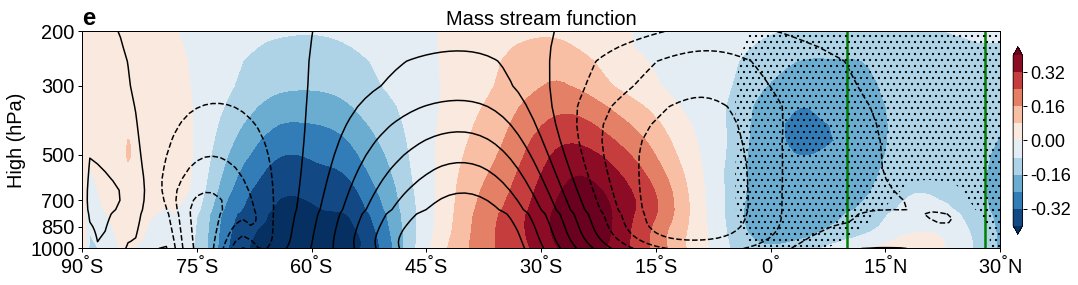

In [28]:
fig = plt.figure(figsize=(16.45,4))
ax1 = plt.subplot(1, 1, 1)
ax1.set_detail()
ax1.axvline(10,c='g',lw=2.5)
ax1.axvline(28,c='g',lw=2.5)
ax1.set_ylabel('High (hPa)',fontsize=20)
ax1.set_yscale('symlog')
ax1.set_yticks([200,300,500,700,850,1000])
ax1.set_yticklabels(['200','300','500','700','850','1000'],fontsize=20)
ax1.set_ylim(1000,200) 
ax1.set_xlim(-90,30) 
ax1.set_xticks([-90,-75,-60,-45,-30,-15,0,15,30])
ax1.set_xticklabels([r'90$^\degree$S',r'75$^\degree$S',
        r'60$^\degree$S',r'45$^\degree$S', r'30$^\degree$S',
         r'15$^\degree$S', r'0$^\degree$',
         r'15$^\degree$N',  r'30$^\degree$N'] ,fontsize=20)
pos = fig.add_axes([0.911,0.175,0.008,0.65])
c1 = ax1.contourf(latv,levv,MLR7.slope[0],levels=np.linspace(-0.4,0.4,11), 
        extend = 'both',zorder=0, cmap=cmaps.MPL_RdBu_r)
c2 = ax1.contour(latv,levv,msfu.mean(0),levels=np.linspace(-7,7,11), 
        extend = 'both',zorder=1, colors = 'k')
ax1.contourf(latv,levv, MLR7.pv_i[0], levels =[0,0.05,1],hatches=['..', None], 
                 zorder=3,colors="none")
cb = fig.colorbar(c1,orientation='vertical',format='%.2f',cax=pos)
cb.ax.set_colorbar(minor='off',fontsize=18)
ax1.set_title("Mass stream function",fontsize=20,loc='center')
ax1.set_title("e",fontsize=24,weight='bold',loc='left')
fig.savefig("/public/home/songqh/project/ISM_impact_Antarctic/figures/response_figures/support-3e.jpeg",dpi=600, bbox_inches='tight')